# Test Sizing

Ultimately, we will develop an engagement model that will be used in predicting when a consituent is likely to respond to a conversion campaign. We need test data to make such predictions. 

## The test data

We expect our engagement model will give us power to select the most promising consitutents for the conversion campaign, reserving the rest for a time when they are more engaged through our cultivation email flow. So that we won't be in the dark, we need to test the success rate of the conversion campaign separate from any sophisticated decision-making. Our hypothesis is that the conversion rate for an uncultivated consitituent, $p_n$, and the conversion rate for a cultivated constituent, $p_c$, are described by the below probability density functions (pdfs):

$$p_n = B(\alpha, \beta)$$
$$p_c = B(\alpha*a, \beta*b)$$

with 
$$\alpha = U(5, 13)$$
$$\beta = U(1000, 1400)$$
$$ a = \Gamma(k=18, \theta=1/15) $$
$$ b = \Gamma(k=18, \theta=1/27) $$

How do we know these are good prior assumptions? The pdfs for $p_n$ and $p_c$ are generated by the code in the next block, and show that for $p_n$ there is a 95% probability it falls between 0.3% and 1.3%, and $p_c$ is expected to be double it, and with roughly double the variance. You can also see the simulated empirical 2.5% and 97.5% quantiles as vertical lines.

/Users/phil/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


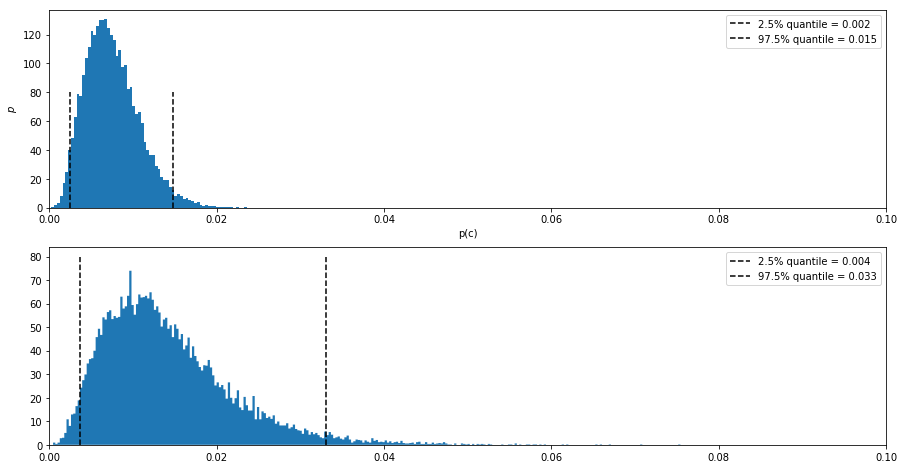

In [1]:
import pymc3 as pm
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

with pm.Model() as ab_testing:
    alpha = pm.Uniform("alpha_n", 5, 13)
    beta = pm.Uniform("beta_n", 1000, 1400)
    p_n = pm.Beta("p_n", alpha=alpha, beta=beta)
    a = pm.Gamma("a", alpha=18, beta=15)
    b = pm.Gamma("b", alpha=18, beta=27)
    p_c = pm.Beta("p(c)", alpha=alpha*a, beta=beta*b)

%matplotlib inline
figsize(15, 8)
plt.title("Prior distributions for $p_n$, $a$, $b$, and $p_c$")
plt.xlim(0, 0.15);

dists = [p_n, p_c]
for i in range(2):
    samples = dists[i].random(size=20000)
    plt.xlabel(dists[i].name)
    plt.ylabel("$p$")
    plt.subplot(2, 1, i+1)
    bins = 70*(i+1)**2
    plt.hist(samples, bins=bins, normed=True, histtype="stepfilled")
    plt.xlim(0, 0.10);
    plt.vlines(np.quantile(samples, 0.025), 0, 80, linestyle="--", label="2.5% quantile = {0:.3f}".format(np.quantile(samples, 0.025)))
    plt.vlines(np.quantile(samples, 0.975), 0, 80, linestyle="--", label="97.5% quantile = {0:.3f}".format(np.quantile(samples, 0.975)))
    plt.legend();


How can we run a minimally-sized test that gives us confidence for moving into the next phase? We seek to confirm that our cultivation flow will indeed increase the likelihood of success for the conversion. Otherwise we need to reform the idea of cultivation since it isn't worth doing as currently conceived. We also want to confirm it **with as few constituents as possible** going through the experiment, so that we can retain constituents for a more optimized experience.

Assuming the true conversion rates will be described by the above distributions, how many samples will give credibility that $p_c > p_n$?

1. We draw a $p_c$ and $p_n$ from the above distributions and take those as being true. 
2. For each constituent sample size: 
3. **[**We simulate giving them the selected treatments several times: 50% with cultivation, 50% without.
4. We update our priors based on the observed data
5. We see how often the posteriors concluded $p_c > p_n$
6. We determine how many of the simulated samples succeeded in proving the hypothesis**]**

In [ ]:
def simulate(samples, lift):
    print('Simulating {0} samples with {1} lift.'.format(samples, lift))
    samples_n = samples
    success_n = 4*samples/500
    samples_c = samples
    success_c = int(4*lift*samples/500)

    # Generate occurrences data
    occurrences_n = np.zeros(samples_n)
    occurrences_n[:success_n] = 1
    occurrences_c = np.zeros(samples_c)
    occurrences_c[:success_c] = 1

    with pm.Model() as results:
        alpha = pm.Uniform("alpha_n", 5, 13)
        beta = pm.Uniform("beta_n", 1000, 1400)
        p_n = pm.Beta("p_n", alpha=alpha, beta=beta)
        observed_n = pm.Bernoulli("observed_n", p_n, observed=occurrences_n)
        a = pm.Gamma("a", alpha=18, beta=15)
        b = pm.Gamma("b", alpha=18, beta=27)
        p_c = pm.Beta("p_c", alpha=alpha*a, beta=beta*b)
        observed_c = pm.Bernoulli("observed_c", p_c, observed=occurrences_c)

        step = pm.Metropolis()
        trace = pm.sample(2000, step=step)
        return (trace[1000:]['p_c']>trace[1000:]['p_n']).mean()


results = [{'samples': samples, 'lift': lift, 'p_success': simulate(samples, lift)} for lift in [0.5, 0.8, 1, 1.2, 1.5, 2] for samples in [500, 1000, 2000, 5000, 10000]]

Simulating 500 samples with 0.5 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 1000 samples with 0.5 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 2000 samples with 0.5 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 5000 samples with 0.5 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 10000 samples with 0.5 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 500 samples with 0.8 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 1000 samples with 0.8 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 2000 samples with 0.8 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 5000 samples with 0.8 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 25% for some parameters.


Simulating 10000 samples with 0.8 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 500 samples with 1 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 1000 samples with 1 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The estimated number of effective samples is smaller than 200 for some parameters.


Simulating 2000 samples with 1 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 5000 samples with 1 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 10000 samples with 1 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 25% for some parameters.


Simulating 500 samples with 1.2 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]
The number of effective samples is smaller than 10% for some parameters.


Simulating 1000 samples with 1.2 lift.


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [p_n]
>Metropolis: [beta_n]
>Metropolis: [alpha_n]


In [ ]:
markdown_str = '| Samples | 50% red | 20% red | Flat | 20% lift | 50% lift | 100% lift |\n|---------|----|----|------|----------|----------|-----------|\n'
for samples in [500, 1000, 2000, 5000, 10000]:
    markdown_str += '| {}'.format(samples)
    for lift in [0.5, 0.8, 1, 1.2, 1.5, 2]:
        record = [i for i,x in enumerate(results) if x['lift'] == lift and x['samples'] == samples][0]
        markdown_str += '| {}%'.format('%.0f' %(results[record]['p_success']*100))
    markdown_str += '|\n'
print(markdown_str)

| Samples | 50% red | 20% red | Flat | 20% lift | 50% lift | 100% lift |
|---------|----|----|------|----------|----------|-----------|
| 500| 53%| 67%| 79%| 73%| 89%| 96%|
| 1000| 34%| 56%| 72%| 78%| 94%| 98%|
| 2000| 16%| 39%| 70%| 81%| 94%| 100%|
| 5000| 1%| 30%| 62%| 87%| 99%| 100%|
| 10000| 0%| 13%| 60%| 92%| 100%| 100%|

# Once we have data

Run the below code once we have any amount of sample size and conversion events for the two experiences (cultivation/no cultivation)

In [ ]:
# Write in the actual data
samples_n = 500
success_n = 4
samples_c = 500
success_c = 8

# Generate occurrences data
occurrences_n = np.zeros(samples_n)
occurrences_n[:success_n] = 1
occurrences_c = np.zeros(samples_c)
occurrences_c[:success_c] = 1


with pm.Model() as results:
    alpha = pm.Uniform("alpha_n", 5, 13)
    beta = pm.Uniform("beta_n", 1000, 1400)
    p_n = pm.Beta("p_n", alpha=alpha, beta=beta)
    observed_n = pm.Bernoulli("observed_n", p_n, observed=occurrences_n)
    a = pm.Gamma("a", alpha=18, beta=15)
    b = pm.Gamma("b", alpha=18, beta=27)
    p_c = pm.Beta("p_c", alpha=alpha*a, beta=beta*b)
    observed_c = pm.Bernoulli("observed_c", p_c, observed=occurrences_c)

    step = pm.Metropolis()
    trace = pm.sample(2000, step=step)
    

pm.plots.traceplot(trace=trace, varnames=['p_n', 'p_c'])#, 'a', 'b'])
pm.plots.plot_posterior(trace=trace[p_n])
pm.plots.plot_posterior(trace=trace[p_c])
pm.plots.autocorrplot(trace=trace, varnames=["p_n", "p_c"]);

Now we have our posterior distributions, but how do we predict the likelihood that $p_c$ > $p_n$? We find how often our optimization method has given a higher value to p_c than to p_n.

In [ ]:
print('{0}% chance that $p_c$ > $p_n$'.format('%.2f' %(trace[:]['p_c']>trace[:]['p_n']).mean()))